# Ligand Similarity Prob Analysis
Plot results from `probability_analysis.py`

In [198]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100/"

## Setup

In [199]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Define Plot Functions

In [225]:
def plot_single_scatter(cluster_data: pl.DataFrame, 
                        x_col: str, 
                        y_col: str, 
                        connect_points: bool, 
                        ax_title: str, 
                        ax_xlabel: str, 
                        ax_ylabel: str, 
                        show_all_xticks: bool,
                        show_parity_line: bool, 
                        correlation_method,
                        color: str,
                        ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.scatter(cluster_data[x_col], cluster_data[y_col], 
                color=color, s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    
    # Connect points with a line
    if connect_points:
        ax.plot(cluster_data[x_col], cluster_data[y_col], color='gray', alpha=0.6, linewidth=1, linestyle='-')
    
    # Customize the subplot
    ax.set_title(ax_title, fontsize=12, fontweight='bold')
    ax.set_xlabel(ax_xlabel, fontsize=10)
    ax.set_ylabel(ax_ylabel, fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis to show all threshold values
    if show_all_xticks:
        ax.set_xticks(sorted(cluster_data[x_col].unique()))
    
    # Add some padding to y-axis
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min * 0.95, y_max * 1.05)

    # add correlation text
    if correlation_method is not None:
        correlation = cluster_data.select(pl.corr(x_col, y_col, method=correlation_method)).item()
        if correlation_method == "spearman":
            corr_symbol = r"$\rho$"
        else:
            corr_symbol = "r"
        ax.text(0.05, 0.95, corr_symbol + f" = {correlation:.3f}", 
                transform=ax.transAxes, fontsize=10, 
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
    # add parity line if requested
    if show_parity_line:
        ax.plot(
            [cluster_data[x_col].min(), cluster_data[x_col].max()],
            [cluster_data[y_col].min(), cluster_data[y_col].max()],
            color = "black",
            linestyle='dashed',
            linewidth=2,
            alpha = 0.5,
        )

In [201]:
def create_multi_scatter_plots(df: pl.DataFrame, 
                            cluster_order: list, 
                            cluster_col: str = "short_name", 
                            x_col: str = "threshold", 
                            y_col: str = "enrichment_factor",
                            xlabel: str  = "Similarity Threshold",
                            ylabel: str = "Enrichment Factor",
                            title: str = "Enrichment Factor vs Similarity Threshold by Kinase Group",
                            connect_points: bool = True,
                            show_all_xticks: bool = True,
                            correlation_method: str = "spearman",
                            show_parity_line: bool = False,
                            n_row: int = 3,
                            n_col: int = 3):
    
    sns.set_style("whitegrid")
    plt.style.use('default')

    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    colors = sns.color_palette("hls", len(cluster_order))

    # Create plots for each cluster
    for i, cluster in enumerate(cluster_order):
        # Calculate subplot position
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Filter data for this cluster
        cluster_data = df.filter(df[cluster_col] == cluster).sort(x_col)
        plot_single_scatter(cluster_data,
                            x_col, 
                            y_col, 
                            connect_points, 
                            f"{cluster}", 
                            xlabel, 
                            ylabel, 
                            show_all_xticks, 
                            show_parity_line, 
                            correlation_method,
                            colors[i],
                            ax = ax)
        
        

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [202]:
def plot_multi_hist(df: pl.DataFrame, 
                    cluster_order: list, 
                    cluster_col: str = "short_name", 
                    count_col: str = "count", 
                    xlabel: str = "N. Unique Assays", 
                    title: str  = "Distribution of N. Assays by Protein Kinase Group",
                    n_row: int = 3,
                    n_col: int = 3,
                    text_x: float = 0.98,
                    text_y: float = 0.98,
                    count_labels: bool = False,
                    color_pallette: str = "hls"):
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    axes_flat = axes.flatten()
    if color_pallette:
        colors = sns.color_palette(color_pallette, len(cluster_order))
    else:
        colors = ["blue"] * len(cluster_order)
    min_count = 0

    for i, cluster_name in enumerate(cluster_order):
        cluster_data = df.filter(pl.col(cluster_col) == cluster_name)
        counts = cluster_data[count_col].to_numpy()
        
        ax = axes_flat[i]
        n_bins = min(len(counts), 50)
        sns.histplot(data=counts, bins=n_bins, stat="percent", ax=ax, alpha=0.8, color=colors[i])
        
        ax.set_title(f'{cluster_name}', fontweight='bold')
        ax.set_xbound(lower=min_count)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Percent')
        
        mean_count = np.mean(counts)
        median_count = np.median(counts)
        n_samples = len(counts)
        stats_text = f'n={n_samples}\nMean: {mean_count:.1f}\nMedian: {median_count:.1f}'
        if count_labels:
            zero_count = (counts == 0).sum()
            lt10_count = (counts < 10).sum()
            stats_text += f'\nCounts = 0: {zero_count}\nCounts < 10: {lt10_count}'
        
        ax.text(text_x, text_y, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=8)

    # hide unused axes
    while i < (n_row * n_col - 1):
        i += 1
        axes_flat[i].axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [203]:
def plot_unique_hist(df: pl.DataFrame, 
                     x_col: str, 
                     id_col: str,
                     log_scale: bool = True):
    df = df.unique(subset=[id_col, x_col])
    sns.histplot(df[x_col], stat="percent",  log_scale=log_scale)

In [204]:
def bar_plot(df: pl.DataFrame, 
             x: str, 
             y: str, 
             bar_title: str, 
             xlabel: str, 
             ylabel: str, 
             ax=None, 
             colors=None, 
             order:list=None, 
             limit_float: bool = False,
             scientific_float_format: bool = False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    if colors is None:
        colors = sns.color_palette("hls", len(df))
    if order is not None:
        df = df.sort(pl.col(x).replace(order, range(len(order))))
    sns.barplot(data=df, x=x, y=y, ax=ax, palette=colors, order=order)
    ax.set_title(bar_title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    m = df[y].max()
    for i, v in enumerate(df[y]):
        text = str(v)
        if limit_float:
            if scientific_float_format:
                text = "{:10.2E}".format(v)
            else:
                text = "{:10.3f}".format(v)
        ax.text(i, v + m * 0.01, 
                text, ha='center', va='bottom', fontweight='bold')

## Load data

In [205]:
family_info_df = pl.read_csv(os.path.join(DATA_DIR,"targets/family_addl_info.tsv"), separator="\t")
family_info_df = family_info_df.with_columns((pl.col("short_name").str.to_uppercase()))

In [206]:
LC_PATH_CL4 = os.path.join(DATA_DIR, "family_clusters", "ligand2cluster-class_level=4.tsv")
ligand_cluster_cl4_df = pl.read_csv(LC_PATH_CL4, separator="\t")

In [207]:
ligand_cluster_cl4_df = ligand_cluster_cl4_df.join(family_info_df, on="protein_class_id")

In [208]:
ligand_cluster_cl4_df.head()

molregno,tid,protein_class_id,cluster,parent_id,pref_name,short_name,class_level
i64,i64,i64,i64,i64,str,str,i64
148,10044,158,2,1100,"""Other protein kinase group""","""OTHER""",4
213,10850,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
213,10850,1289,4,1100,"""AGC protein kinase group""","""AGC""",4
213,10839,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
213,11843,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4


In [209]:
cluster2name_df = ligand_cluster_cl4_df[["cluster", "short_name"]].unique().sort(by="cluster")
cluster2name_df

cluster,short_name
i64,str
1,"""CMGC"""
2,"""OTHER"""
3,"""TK"""
4,"""AGC"""
5,"""CK1"""
6,"""STE"""
7,"""TKL"""
8,"""CAMK"""
9,"""ATYPICAL"""


## Plot per Group

In [210]:
CLASS_LEVEL = 4

In [211]:
cl4_df = pl.read_csv(os.path.join(DATA_DIR, "cluster_stats", f"per_cluster_threshold_analysis_class_level={CLASS_LEVEL}.tsv"), separator="\t")
cl4_df = cl4_df.join(cluster2name_df, on="cluster")
cl4_df

cluster,threshold,conditional_probability,baseline_probability,high_sim_pairs,enrichment_factor,cluster_size,short_name
i64,f64,f64,f64,i64,f64,i64,str
1,0.2,0.020502,0.016261,73603,1.260786,1275,"""CMGC"""
2,0.2,0.006921,0.005284,24848,1.309923,727,"""OTHER"""
3,0.2,0.546986,0.286165,1963689,1.911433,5347,"""TK"""
4,0.2,0.007484,0.006544,26869,1.143713,809,"""AGC"""
5,0.2,0.000015,0.000002,55,9.809878,13,"""CK1"""
…,…,…,…,…,…,…,…
5,0.9,0.000698,0.000002,1,446.839292,13,"""CK1"""
6,0.9,0.015352,0.001804,22,8.51028,425,"""STE"""
7,0.9,0.040475,0.00656,58,6.16979,810,"""TKL"""


In [212]:
cluster_order = ['CK1', 'STE', 'ATYPICAL', 'CAMK', 'AGC', 'TKL', 'CMGC', 'OTHER', 'TK'] # this is just so colors match between plots

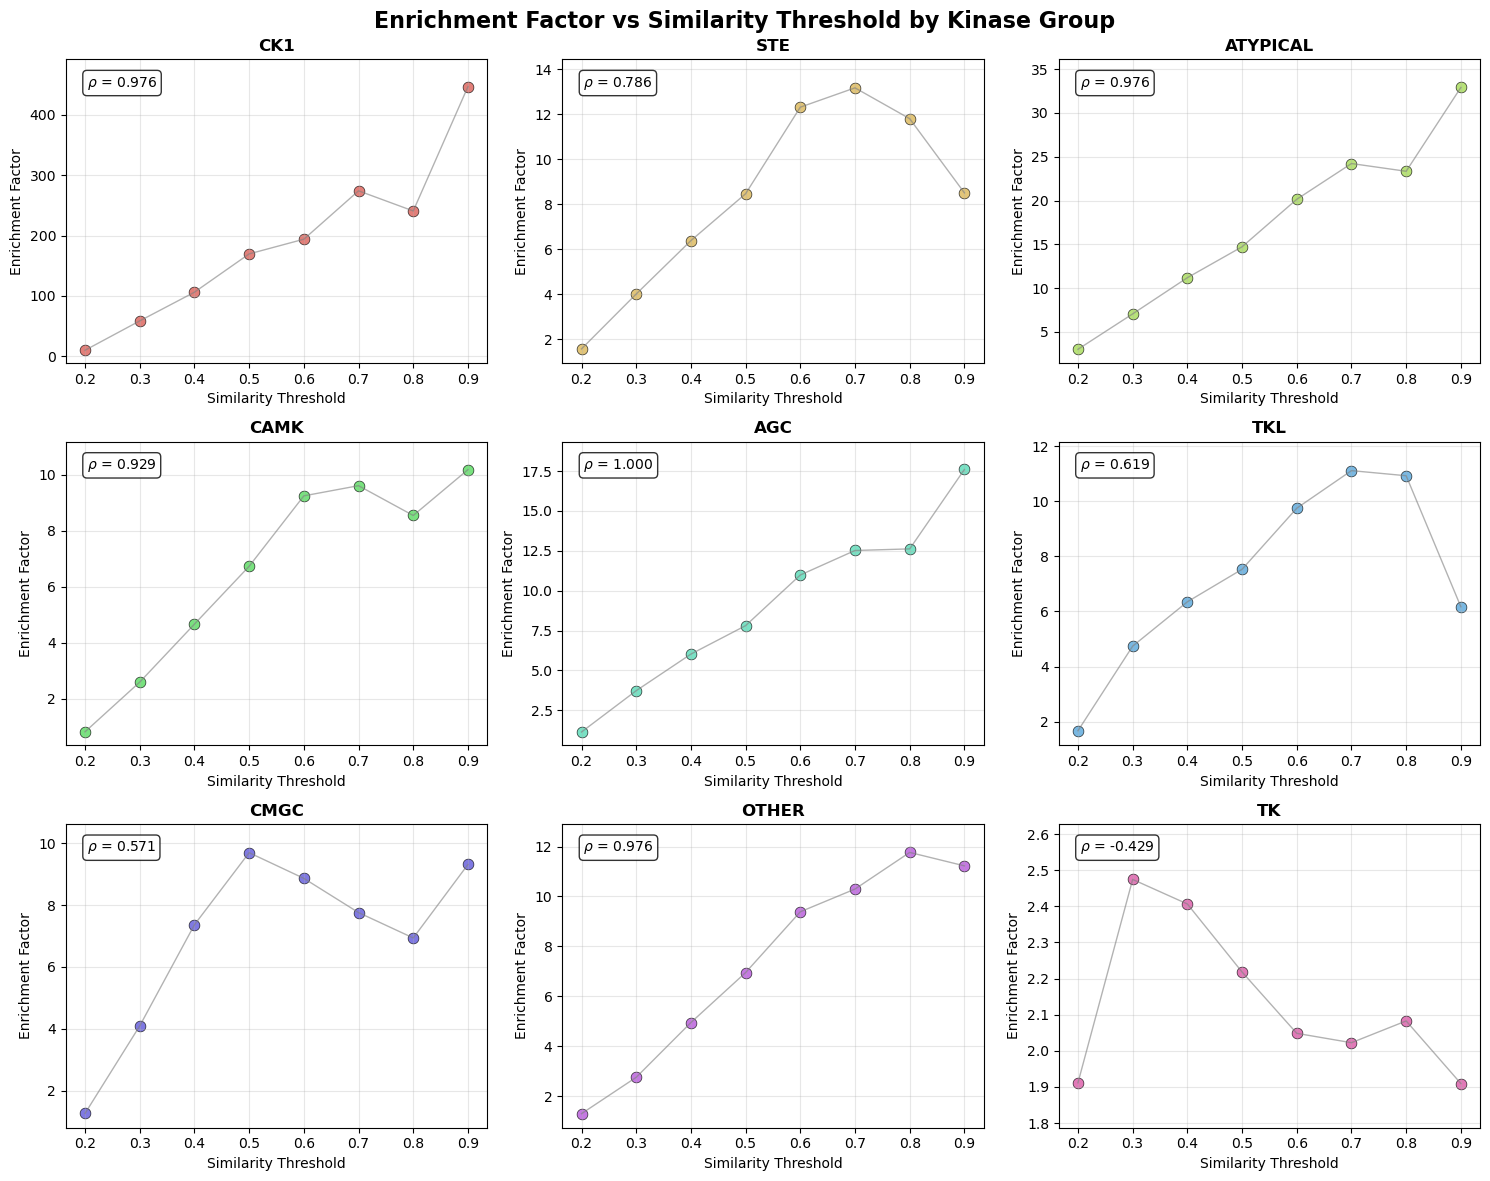

In [213]:
# TODO: need to add confidence bars to each point here
# maybe bootstrap to calculate enrichment factor in probability_analysis.py?
create_multi_scatter_plots(cl4_df, cluster_order)

/tmp/ipykernel_45061/3719789086.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x, y=y, ax=ax, palette=colors, order=order)


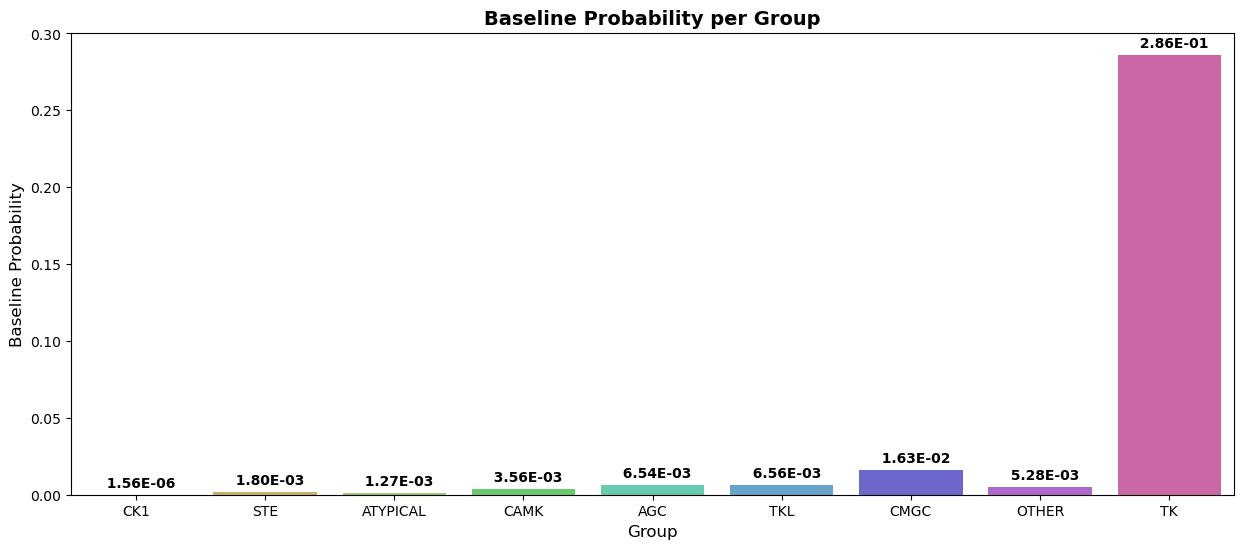

In [214]:
# show baselines
cl4_uni_df = cl4_df.unique(subset=["cluster", "baseline_probability"])["cluster", "short_name", "baseline_probability"]
colors = sns.color_palette("hls", len(cluster_order))
bar_plot(cl4_uni_df, x="short_name", 
         y="baseline_probability", 
         bar_title="Baseline Probability per Group", 
         ylabel="Baseline Probability", 
         xlabel="Group", 
         colors=colors, 
         order=cluster_order, 
         limit_float=True,
         scientific_float_format=True)

In [215]:
# note that the sum is the probability that 2 (TWO) randomly selected ligands belong to the same group
# thus we don't expect it to be 1
cl4_uni_df["baseline_probability"].sum()

0.32745446167150016

## Plot per Assay

In [216]:
assay_df = pl.read_csv(os.path.join(DATA_DIR, "cluster_stats", f"per_cluster_threshold_analysis_per_assay.tsv"), separator="\t")

Text(0.5, 1.0, 'Number of Active Ligands per Assay')

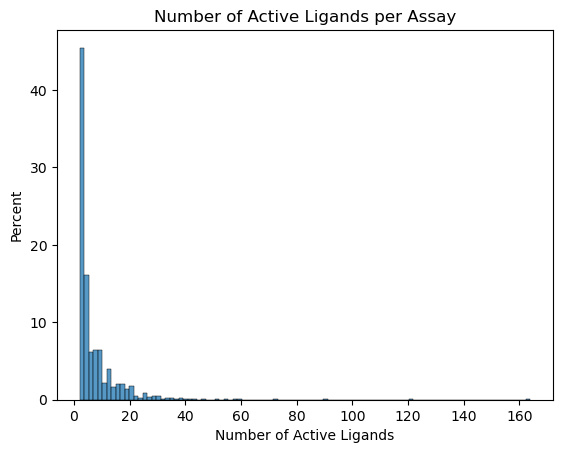

In [217]:
# plot number of active ligands per assays (note: minimum of 2 active ligands here since this data came from analyzing similarity values)
sns.histplot(assay_df["cluster_size"], stat="percent", bins=100)
plt.xlabel("Number of Active Ligands")
plt.title("Number of Active Ligands per Assay")

In [218]:
assay_df_filt = assay_df.filter(assay_df["high_sim_pairs"] > 0)

In [223]:
adf = assay_df_filt.group_by("threshold").agg(pl.col('enrichment_factor').mean().alias('avg_enrichment_factor')).sort("threshold")
adf

threshold,avg_enrichment_factor
f64,f64
0.2,13.363685
0.3,77.924974
0.4,190.606134
0.5,350.205202
0.6,620.90028
0.7,1009.631794
0.8,1794.398722
0.9,4644.303235


In [220]:
thresh_order = adf["threshold"]

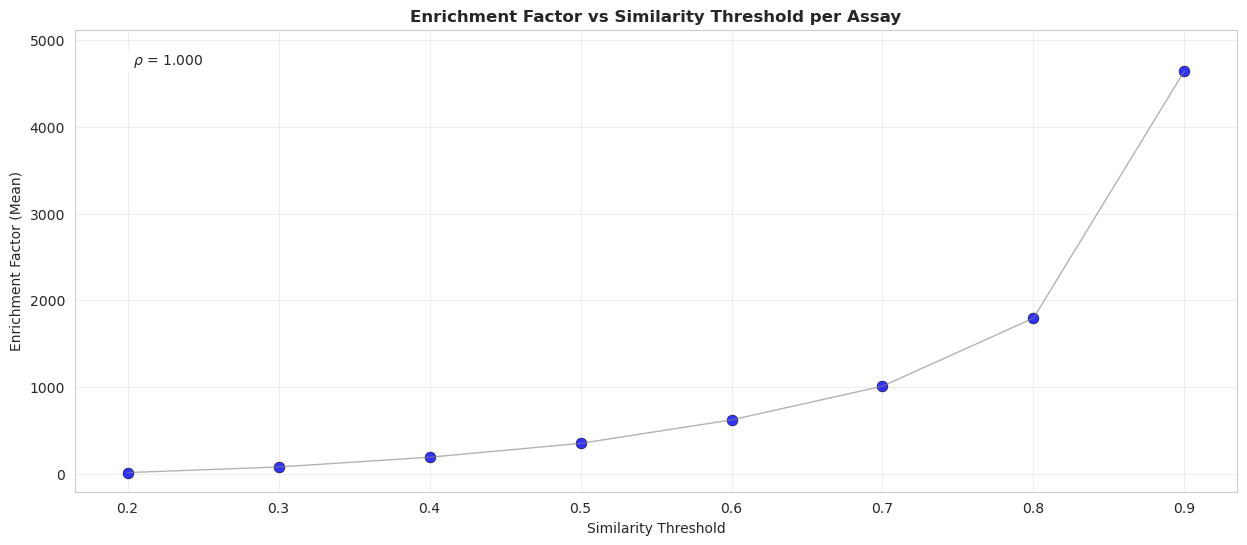

In [228]:
# TODO: add CI, I think can just calculate percentile interval from data itself
plot_single_scatter(adf, 
                    "threshold", 
                    "avg_enrichment_factor", 
                    connect_points=True, 
                    ax_title="Enrichment Factor vs Similarity Threshold per Assay",
                    ax_xlabel="Similarity Threshold",
                    ax_ylabel="Enrichment Factor (Mean)",
                    show_all_xticks=True,
                    show_parity_line=False,
                    correlation_method="spearman",
                    color="blue")

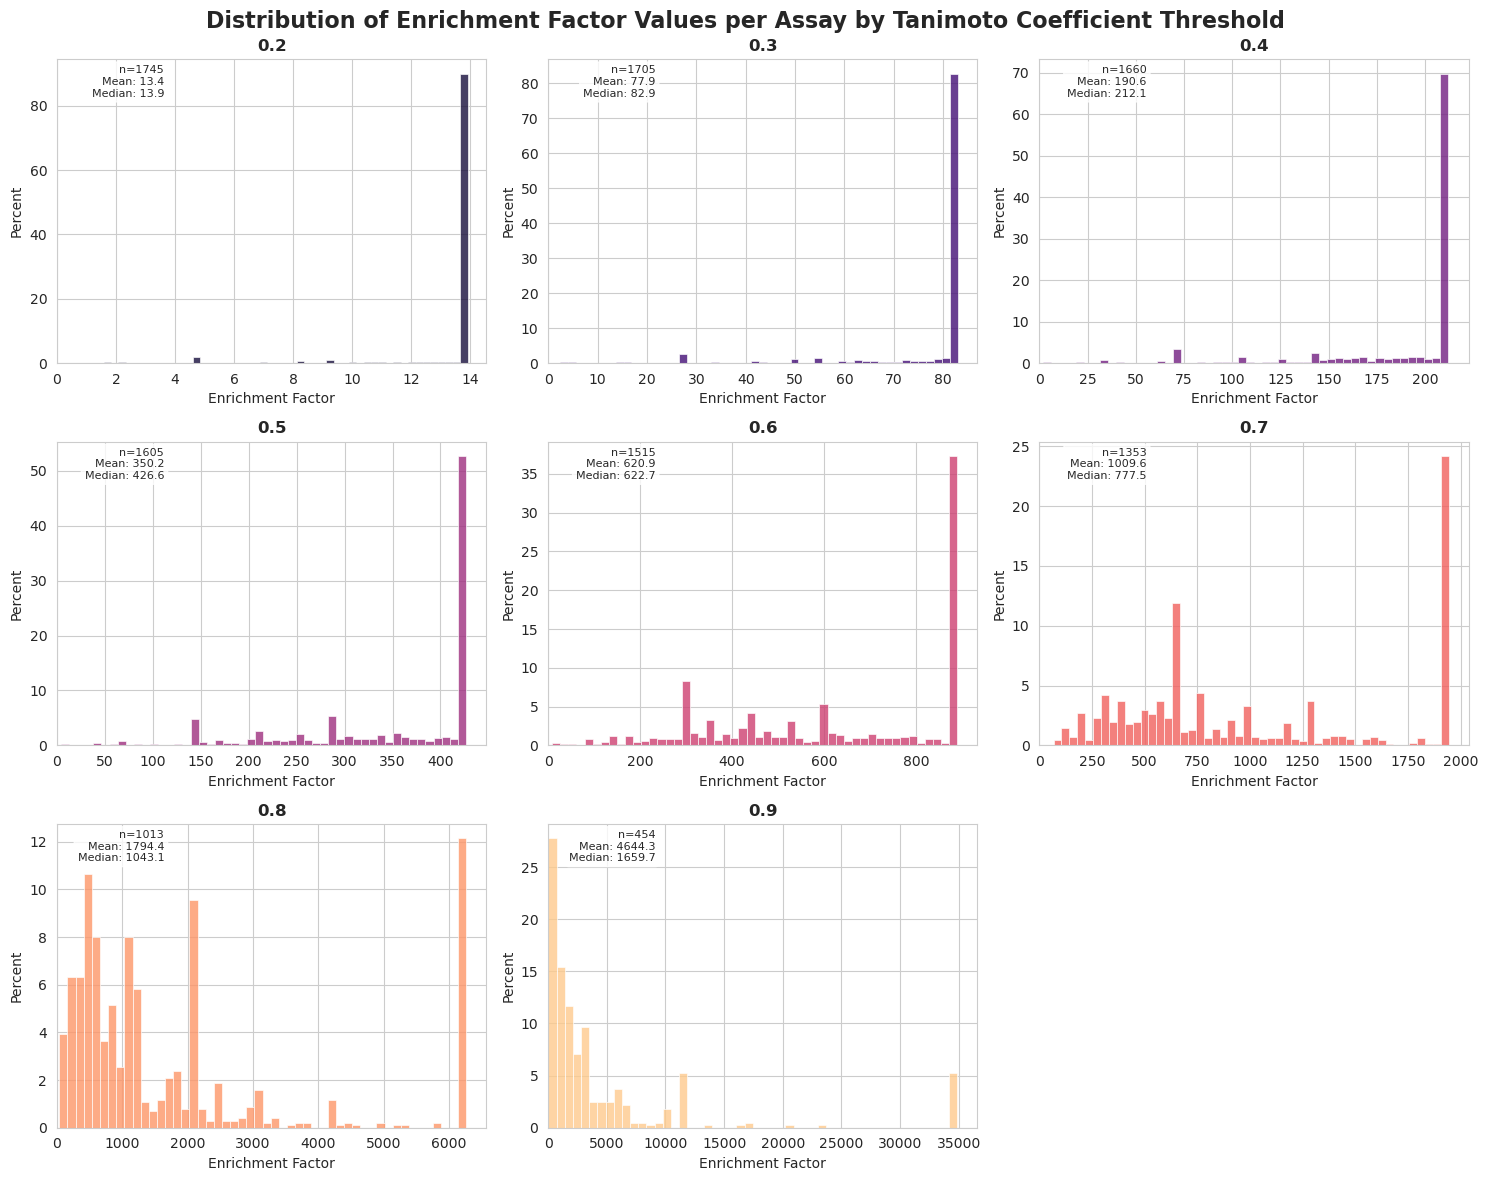

In [222]:
# TODO: should double-check why there are so many values at the right-end of each histogram here
plot_multi_hist(assay_df_filt, 
                thresh_order, 
                cluster_col="threshold", 
                count_col="enrichment_factor", 
                xlabel="Enrichment Factor",
                title="Distribution of Enrichment Factor Values per Assay by Tanimoto Coefficient Threshold",
                n_row=3, 
                n_col=3,
                text_x=0.25,
                color_pallette="magma")